In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt
import torch.nn.functional as F
from torchflare.experiments import Experiment

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
train_dataset = MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)


<IPython.core.display.Javascript object>

In [4]:
train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset, [50000, 10000]
)

<IPython.core.display.Javascript object>

In [5]:
bs = 64
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=bs, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=bs, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=bs, shuffle=False
)

<IPython.core.display.Javascript object>

In [10]:
class VAE(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.d = d
        self.encoder = nn.Sequential(
            nn.Linear(784, self.d ** 2), nn.ReLU(), nn.Linear(self.d ** 2, self.d * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.d, self.d ** 2),
            nn.ReLU(),
            nn.Linear(self.d ** 2, 784),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, self.d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar

<IPython.core.display.Javascript object>

In [11]:
# Reconstruction + β * KL divergence losses summed over all elements and batch

def loss_function(x_hat, x, mu, logvar, β=1):
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 784), reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + β * KLD



<IPython.core.display.Javascript object>

In [12]:
class VAEExperiment(Experiment):
    def __init__(self, **kwargs):
        super(VAEExperiment, self).__init__(**kwargs)

    def compute_loss(self):

        x_hat, mu, logvar = self.preds
        self.loss = self.criterion(x_hat, self.x, mu, logvar)

<IPython.core.display.Javascript object>

In [13]:
exp = VAEExperiment(num_epochs=30, fp16=False, device="cuda", seed=42)

<IPython.core.display.Javascript object>

In [15]:
exp.compile_experiment(
    module=VAE,
    module_params={"d": 20},
    optimizer="Adam",
    optimizer_params={"lr": 3e-3},
    criterion=loss_function,
)

<IPython.core.display.Javascript object>

In [16]:
exp.fit_loader(train_loader, val_loader)


Epoch: 1/30
Train: 782/782 [=========================]- 12s 16ms/step - train_loss: 8767.5388
Valid: 157/157 [=========================]- 1s 5ms/step - val_loss: 6957.6839

Epoch: 2/30
Train: 782/782 [=========================]- 6s 7ms/step - train_loss: 7295.8329
Valid: 157/157 [=========================]- 1s 6ms/step - val_loss: 6658.1921

Epoch: 3/30
Train: 782/782 [=========================]- 6s 8ms/step - train_loss: 7112.5864
Valid: 157/157 [=========================]- 1s 5ms/step - val_loss: 6554.8810

Epoch: 4/30
Train: 782/782 [=========================]- 6s 7ms/step - train_loss: 7030.2678
Valid: 157/157 [=========================]- 1s 5ms/step - val_loss: 6437.6711

Epoch: 5/30
Train: 782/782 [=========================]- 6s 7ms/step - train_loss: 6974.3846
Valid: 157/157 [=========================]- 1s 5ms/step - val_loss: 6410.1305

Epoch: 6/30
Train: 782/782 [=========================]- 5s 7ms/step - train_loss: 6932.6089
Valid: 157/157 [=========================]- 1s 5ms

<IPython.core.display.Javascript object>

In [17]:
# Displaying routine
def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 28, 28)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')



<IPython.core.display.Javascript object>

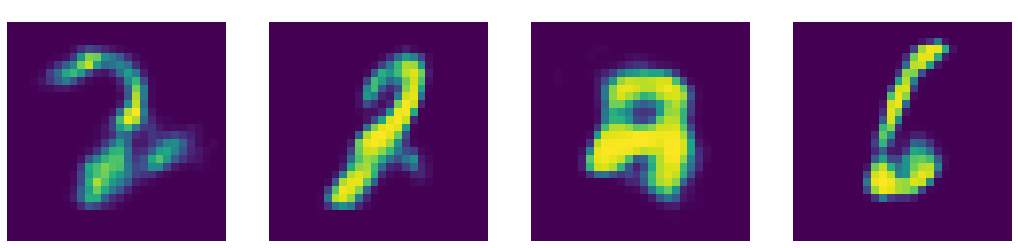

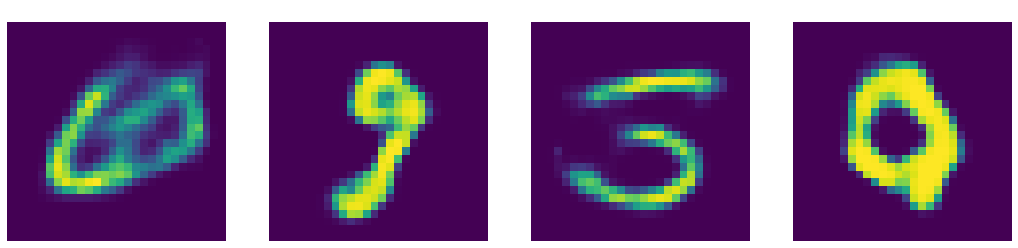

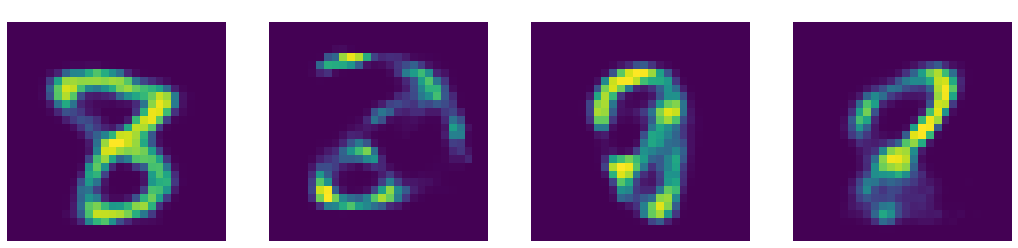

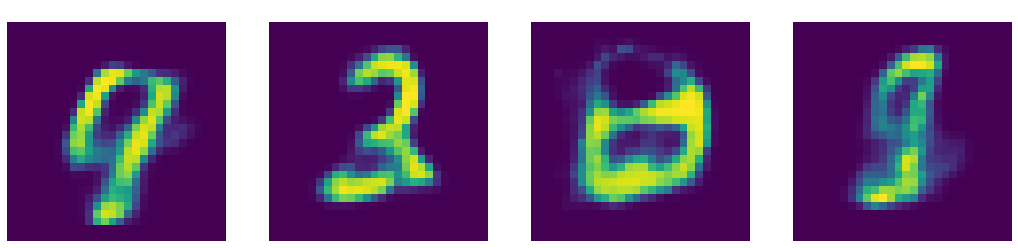

<IPython.core.display.Javascript object>

In [18]:
N = 16
device = "cuda"
z = torch.randn((N, d)).to(device)
sample = exp.model.decoder(z)
display_images(None, sample, N // 4, count=True)